# Recurrent Neural Network
___
This notebook will explore building a recurrent neural network (RNN) to forecast the bitcoin price. RNN's are best used for sequential data like time series or natural language processing (NLP). A neural network allows the machine the ability to train itself based on the data it is given. Machine learning models (such as exponential smoothing and ARIMA) require the user to train the machine based on its parameters. Neural networks are able to train itself without the user making any adjustments. The one caveat to this is the neural network does need to be designed by the user and the design is where adjustments by the user are made.

The metric used to compare the models is the Residual Sum of Squares (RSS). The RSS is also called the Sum of Squared Residuals (SSR). The loss metric that is used when the model is compiled is the Mean Squared Error (MSE) as this is the standard loss metric for regression models. The RSS will be calculated manually after predictions are made. While the AIC has been used in the previous notebooks, the focus in this one will be on the RSS. As previously established (for those familiar), the AIC can be thought of as the training score and the RSS can be thought of as the testing score. While best practice would be to find a happy balance between the two, the focus here will be to maximize the testing score.

The two types of RNN's that were explored are Gated Recurrent Network (GRU) and Long Short Term Memory (LSTM). These are two common network architectures that are helpful in solving time-series problems. The main difference between GRU and LSTM is that GRU has two gates that the data will go through while LSTM has three. Which architecture is best for the model depends on the data that is being modeled so both were created as an initial test before building the better one out deeper.

For a neural network the data needs to be scaled. Traditional scalers like `StandardScaler` or `MinMaxScaler` are the most common types, but punish data points that are outliers. Unlike these two examples, `RobustScaler` is not influenced by a few number of very large marginal outliers unlike other scalers. The lowest price of Bitcoin in the data is around $65 and the high is over $61K: the assumption is other scalers would treat these extreme values as outliers while `RobustScaler` will not.

## Table of Contents

- **[Import Libraries & DataFrame](#1)**
- **[Baseline GRU Neural Network](#2)**
- **[Basline LSTM Neural Network](#3)**
- **[GRU Neural Network GridSearch](#4)**
- **[GRU Neural Network Expanded](#5)**
- **[Conclusion & Recommendations](#6)**

<a id="1"></a>
## Import Libraries and Data

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
# import daily data
daily = pd.read_csv('./data/daily_clean.csv')

# change dat col to datetime
daily['date'] = pd.to_datetime(daily['date'])

# set date as index
daily.set_index('date', inplace=True)

# sort by index
daily.sort_index(inplace=True)

# set training and testing ranges
train_close = daily['close'][:-90]
test_close = daily['close'][-90:]

In [3]:
# insatiate scaler 
close_scaler = RobustScaler()

# scale the closing data
train_close_sc = close_scaler.fit_transform(train_close.values.reshape(-1,1))
test_close_sc = close_scaler.transform(test_close.values.reshape(-1,1))

In [4]:
# time series generator for closing data
train_sequence = TimeseriesGenerator(train_close_sc, train_close_sc, length=30, batch_size=32)
test_sequence = TimeseriesGenerator(test_close_sc, test_close_sc, length=30, batch_size=32)

<a id="2"></a>
## Baseline GRU Neural Network

---
This section builds out a simple GRU neural network with one hidden layer. The GRU architecture will pass the data through two gates: reset and update gates. The reset gate tells the model how much of the previous data to forget while the update gate tells the model how much of the previous data to keep.

The activation used in all layers except the output layer are `relu` because this is a regression model forecasting the price of Bitcoin. The `relu` activation will provide a continuous value for the data so long as a threshold is reached. The output layer contains a linear activation because the model is a regresssion model.

For simplicty the baseline models all have one hidden layer. The number of neurons chosen were 32 for the first layer and 16 for the second (hidden) layer, these were selected as they are powers of 2 and it felt like the appropriate place to begin.

Through trial and error the epoch value was reached: during previous attempts the model needed more than just 10 or 20 epochs in order to better optimize its loss function. The `batch_size` argument is set to 32 as this is best practice.

In [5]:
# insatiate baseline model
baseline_rnn = Sequential()

# input layer
baseline_rnn.add(GRU(32, activation='relu', return_sequences=True, input_shape=train_sequence[0][0][0].shape))

# hidden layer - set return sequence false as it is last layer before dense
baseline_rnn.add(GRU(. activation='relu', return_sequences=False))

# output layer
baseline_rnn.add(Dense(1))

# get the summary
baseline_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile the model
baseline_rnn.compile(optimizer='adam', loss='mse')

In [9]:
# fit the data
gru_baseline_history_close = baseline_rnn.fit(train_sequence, validation_data=test_sequence, epochs=50, batch_size=32)

Epoch 1/50
87/87 [==============================] - 7s 39ms/step - loss: 0.2290 - val_loss: 3.0455
Epoch 2/50
87/87 [==============================] - 2s 27ms/step - loss: 0.0047 - val_loss: 0.1591
Epoch 3/50
87/87 [==============================] - 2s 24ms/step - loss: 0.0037 - val_loss: 0.1530
Epoch 4/50
87/87 [==============================] - 3s 38ms/step - loss: 0.0032 - val_loss: 0.4697
Epoch 5/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0047 - val_loss: 0.1077
Epoch 6/50
87/87 [==============================] - 3s 30ms/step - loss: 0.0024 - val_loss: 0.1304
Epoch 7/50
87/87 [==============================] - 3s 31ms/step - loss: 0.0024 - val_loss: 0.0869
Epoch 8/50
87/87 [==============================] - 3s 32ms/step - loss: 0.0026 - val_loss: 0.1220
Epoch 9/50
87/87 [==============================] - 3s 39ms/step - loss: 0.0029 - val_loss: 0.0825
Epoch 10/50
87/87 [==============================] - 3s 31ms/step - loss: 0.0016 - val_loss: 0.2042
Epoch 11/

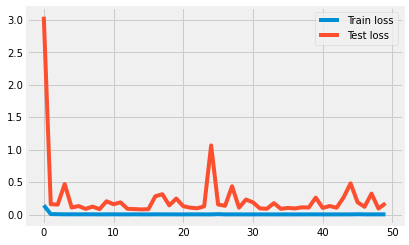

In [10]:
# plot the training and testing MSE
plt.plot(gru_baseline_history_close.history['loss'], label='Train MSE')
plt.plot(gru_baseline_history_close.history['val_loss'], label='Test MSE')
plt.title('Baselin GRU Loss Function')
plt.xlabel('Epochs')
plt.ylabel('MSE Value')
plt.legend();

From the above plot, the testing loss value quickly drops to below 0.5 and most epochs have a loss value below 0.5. This is a strong reading and could suggest early stopping as a possible option to expand this model given how stagnent the loss seems to be after about 10 epochs.

In [13]:
# generate predictions
gru_preds = baseline_rnn.predict(test_sequence)

# unscale the predictions
gru_preds_unscaled = close_scaler.inverse_transform(gru_preds)

In [14]:
# convert the predictions to a df 
# set the test index as this index
gru_close_baseline_pred_df = pd.DataFrame(gru_preds_unscaled, index=test_close.index[30:], columns=['forecast'])

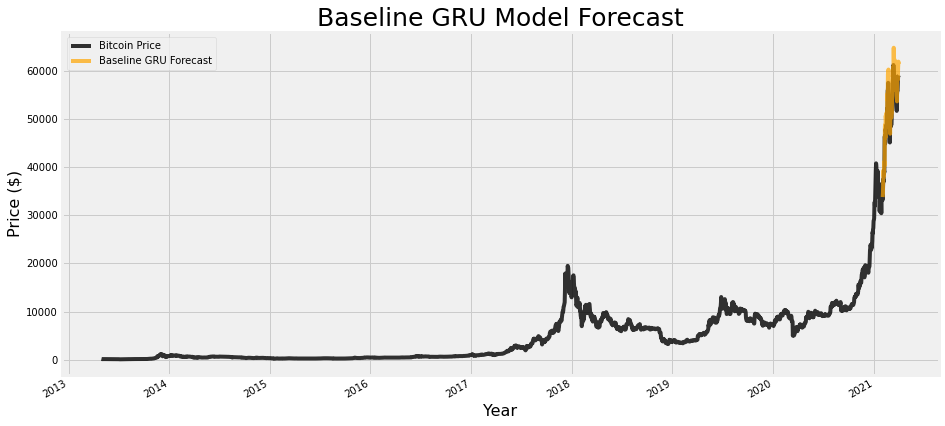

In [15]:
# plot true values
daily['close'].plot(alpha = 0.8, color='black', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot the fitted values
gru_close_baseline_pred_df['forecast'].plot(alpha=0.7,color='orange', label='Baseline GRU Forecast', legend=True)

# add title/x/y labels
plt.title('Baseline GRU Model Forecast', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

In [16]:
# calculate RSS
metrics.mean_squared_error(test_close[30:], gru_close_baseline_pred_df) * 60

527310145.44964737

With a RSS of 527,310,145.44964737 the baseline GRU model is a significant improvement over any previous model created. None of the RSS optimized gridsearched models in the previous notebooks were able to return a RSS below one billion. 

It is worth noting that this RSS score comes from only 60 forecasted values while the other models created 90 forecasted values. The 30 missing values are from the `TimeseriesGenerator` transformer: the length arguement accounts for those missing forecasts. This is not ideal but given the seasonality at a monthly level it seemed very important to have the length be set to that window size. 

The RSS can be estimated for a full 90-day forecast: if the 527 million RSS comes from a forecast that is two thirds the size of other forecasts. Using quick ration math (527:x = 2:3), the estimate for a full 90-day forecast would be about 790 million - which is still well below and other model created. 

<a id="3"></a>
## Baseline LSTM Neural Network
___
This section builds out a simple LSTM neural network with one hidden layer. The LSTM architecture will pass the data through three gates: forget gate, input gate, and output gate. The forget gate decides what information should be thrown away or kept. The input gate decides what values of the previous hidden state to keep. The output gate decides what the next hidden state should be.

All other inputs are the same as the baseline GRU model.

In [19]:
# baseline LTSM
# insatiate baseline model
baseline_lstm = Sequential()

# input layer
baseline_lstm.add(LSTM(32, activation='relu', return_sequences=True, input_shape=train_sequence[0][0][0].shape))

# hidden layer - set return sequence false as it is last layer before dense
baseline_lstm.add(LSTM(16, activation='relu', return_sequences=False))

# output layer
baseline_lstm.add(Dense(1))

# get the summary
baseline_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [20]:
# compile the model
baseline_lstm.compile(optimizer='adam', loss='mse')

# fit the data
lstm_baseline_history = baseline_lstm.fit(train_sequence, validation_data=test_sequence, epochs=50, batch_size=32)

Epoch 1/50
87/87 [==============================] - 5s 31ms/step - loss: 1.6453 - val_loss: 267.3922
Epoch 2/50
87/87 [==============================] - 3s 28ms/step - loss: 0.1422 - val_loss: 129.7725
Epoch 3/50
87/87 [==============================] - 3s 30ms/step - loss: 0.1405 - val_loss: 163.5303
Epoch 4/50
87/87 [==============================] - 3s 32ms/step - loss: 0.1617 - val_loss: 223.4449
Epoch 5/50
87/87 [==============================] - 2s 26ms/step - loss: 0.0872 - val_loss: 72147.7031
Epoch 6/50
87/87 [==============================] - 2s 29ms/step - loss: 0.1155 - val_loss: 15656.1709
Epoch 7/50
87/87 [==============================] - 3s 32ms/step - loss: 0.0399 - val_loss: 43484.3906
Epoch 8/50
87/87 [==============================] - 3s 32ms/step - loss: 0.0307 - val_loss: 10838.1367
Epoch 9/50
87/87 [==============================] - 2s 25ms/step - loss: 0.0794 - val_loss: 592.5872
Epoch 10/50
87/87 [==============================] - 2s 27ms/step - loss: 0.0293 - 

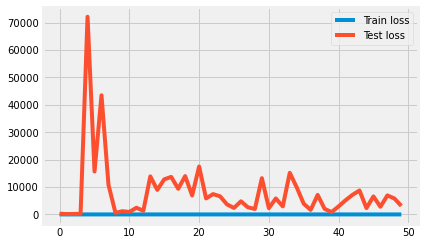

In [21]:
plt.plot(lstm_baseline_history.history['loss'], label='Train loss')
plt.plot(lstm_baseline_history.history['val_loss'], label='Test loss')
plt.legend();

Unlike with the GRU neural network, the LSTM had a much higher testing loss value. The expectation is the RSS will be significantly higher than the RSS from the GRU model, and could even be higher than some of the models that were previously created.

In [22]:
# generate forecast
lstm_preds = baseline_lstm.predict(test_sequence)

# unscale the forecast
lstm_preds_unscaled = close_scaler.inverse_transform(lstm_preds)

In [23]:
# create a df with the forecast
lstm_close_baseline_pred_df = pd.DataFrame(lstm_preds_unscaled, index=test_close.index[30:], columns=['forecast'])

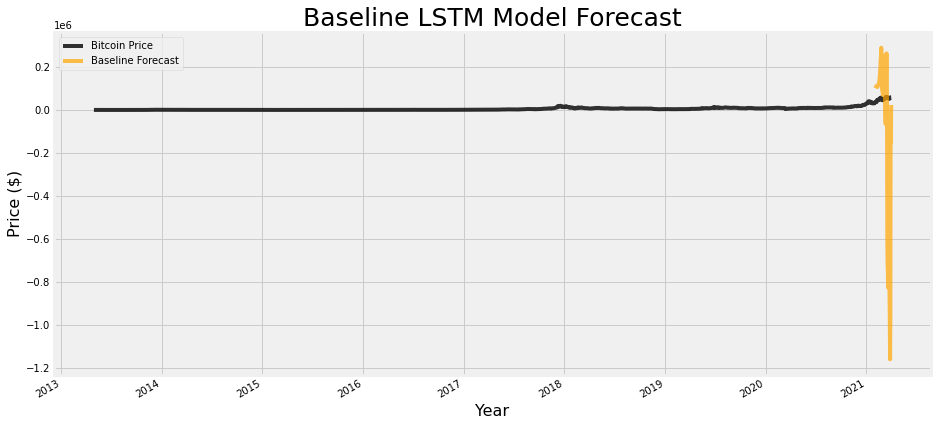

In [24]:
# plot true values
daily['close'].plot(alpha = 0.8, color='black', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot the fitted values
lstm_close_baseline_pred_df['forecast'].plot(alpha=0.7,color='orange', label='Baseline Forecast', legend=True)

# add title/x/y labels
plt.title('Baseline LSTM Model Forecast', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

In [26]:
# calculate RSS
metrics.mean_squared_error(test_close[30:], lstm_close_baseline_pred_df) * 60

9479719403159.566

After seeing the above plot, the expectation would be for the RSS to be terrible. 9,479,719,403,159.566 is the worst RSS score of any model created. No model forecasted a negative price for Bitcoin. 

The most likely reason for this is because of the nature of LSTM: it will still give credence to older Bitcoin prices. While this can be helpful in capitalizing on moving averages, the time period it is going back to check may be too large. In the EDA notebook, there was a candlestick chart of Bitcoin's price over the last year (image below for reference). That chart showed the price of Bitcoin came down to test the 50-day moving average multiple times. Price actions like this validate the use of moving averages and allowing these to be factored into the model is essential in properly forecasting the price of Bitcoin.

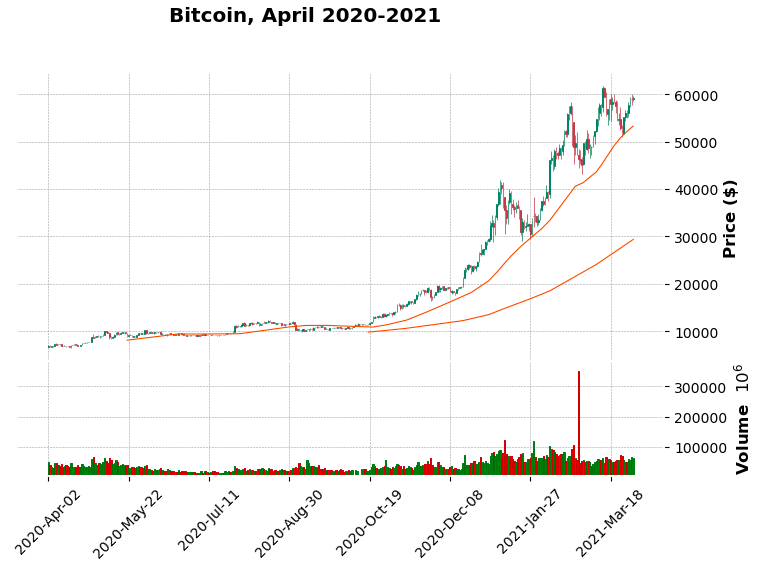

The next section willl focus on building out the GRU model and trying to find the optimal parameters.

<a id="4"></a>
## GRU Neural Network GridSearch
___
This section will build out a GRU neural network GridSearch because the GRU baseline network was the better of the two architectures created. 

The GridSearch will search over the following parameters: neurons, layers, dropout rate, and epochs. The neurons will be kept in the power of two but checked to see if more or less neurons will help the forecast. The number of layers in the model will be checked to see if adding more layers will help the forecast. Dropout regularization and a dropout rate will be incorporated in this model to see if including this layer will help the forecast. The number of epochs in the network will also be be checked to see if shorter periods could be just as efficient as longer periods.

The Dropout layer is a regularization technique designed for neural networks. This layer will randomly drop (turn off) nodes in the neural network during the training phase depending on the dropout rate that is specified. This is a regularization technique to avoid overfitting. Other regularization techniques include weight decay and early stopping. Early stopping does exactly what it sounds like: it stops the model early if the loss metric is decreasing (or increasing if it is measuring accuracy). While this may be helpful, rather than have the model stop early, gridsearching over smaller epoch values should return simmilar results. Weight decay uses Ridge regularization on the neural network and could be a valid option. Given time constraints dropout regularization was used for personal preference but in future models running a GridSearch with weight decay is a valid option. 

In order to use GridSearchCV on a neural network, a function needs to be built for the neural network. Then the function's hyperparameters are what GridSearchCV will search over. As a result it may be beneficial to create multiple model functions and GridSearch over each separately. 

NOTE: The GridSearch was unable to work due to the classes being used on the data. A deeper explanation is found at the end of this section, but the code to run the GridSearch has been commented out as it will result in an error the way it is currently written.

In [78]:
# build a neural network function that will have the previously specified parameters 
def rnn_gs(hidden_neurons=32, hidden_layers=3, dropout=0.5):
    # insatiate the model
    rnn = Sequential()
    
    # add layers using a for loop
    for layer in range(hidden_layers):
        # specify the first layer as it needs the input shape
        if layer ==0:
            rnn.add(GRU(hidden_neurons, 
                        activation='relu', 
                        return_sequences=True, 
                        input_shape=train_sequence[0][0][0].shape))
        # add the remaining layers - specify that the second to last hidden layer needs return sequence False
        elif layer == (hidden_layers-1):
            rnn.add(GRU(hidden_neurons,
                       activation='relu',
                       return_sequences=False))
        else:
            rnn.add(GRU(hidden_neurons, activation='relu', return_sequences=True))
        # add a dropout layer after each layer
        rnn.add(Dropout(dropout))
        
    # set output layer
    rnn.add(Dense(1))
    
    # compile the model
    rnn.compile(loss='mse', optimizer='adam')
    
    return rnn

In [79]:
# use the keras scikit learn wrapper
rnn = KerasRegressor(build_fn=rnn_gs, batch_size=32, verbose=0)

# create the params for the gridsearch
param_grid = {
    'hidden_neurons': [32, 48, 64],
    'hidden_layers': [3, 5, 7],
    'dropout': [0.1, 0.25, 0.5],
    'epochs': [10, 20, 30, 50]
}

In [135]:
# this code has been commented out to allow others to run this notebook from top to bottom. this code if run as is will error out

# run GridSearchCV
#gs = GridSearchCV(rnn, param_grid, cv=3)

# fit the gs
#gs.fit(train_sequence, train_sequence)

Unfortunately the `GridSearchCV`, `KerasRegressor`, and `TimeseriesGenerator` were not on the same page and as a result the GridSearch errored out. The cause for this error is from the input values being running through a `train_test_split` inside of the `GridSearchCV`. The values from the `TimeseriesGenerator` do not like this and as a result the code errored out.

A workaround to this problem would be to build a custom class to replace the `KerasRegressor`. The custom class should perform in the same way as the `KerasRegressor` and `TimeseriesGenerator` all in one class. Despite this custom class seeming very simple, this is an issue that multiple people are attempting to solve [link 1](https://stackoverflow.com/questions/59118239/is-there-anyway-to-use-fit-generator-method-with-kerasregressor-wrapper) [link 2](https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/) and will be part of the final recommendations. If there is a simpler solution to this issue please let me know as I would love to solve this.

Because the GridSearch was not successful, a manual GridSearch over select hyperparameters will be done in the next section to see if the initial GRU model can be improved.

## <a id="5"></a>
## GRU Neural Network Expanded
___
This section explores a handful of GRU neural networks that would have been created in the GridSearch section. The `rnn_gs` function that was created will be used to help streamline the model building process.

In lieu of a GridSearch done by the computer, the function created will serve as the foundation to perform manual GridSearches. To begin, three random GridSearches were done and analyzed to help judge how to adjust the next batch of three GridSearches. Once an initial 6 models were created and interpreted, then specified parameters were tested until a network was created that outperformed the baseline GRU network.

In [82]:
# build out the gru model with the default function values
gru_1 = rnn_gs(hidden_neurons=32, hidden_layers=3, dropout=0.5)

# fit the first model
gru_1_history= gru_1.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 9s 51ms/step - loss: 0.3031 - val_loss: 0.7958
Epoch 2/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0815 - val_loss: 5.2017
Epoch 3/30
87/87 [==============================] - 4s 40ms/step - loss: 0.0494 - val_loss: 1.7143
Epoch 4/30
87/87 [==============================] - 3s 38ms/step - loss: 0.0935 - val_loss: 2.1821
Epoch 5/30
87/87 [==============================] - 4s 44ms/step - loss: 0.1095 - val_loss: 4.4071
Epoch 6/30
87/87 [==============================] - 3s 38ms/step - loss: 0.1229 - val_loss: 2.7176
Epoch 7/30
87/87 [==============================] - 3s 36ms/step - loss: 0.0529 - val_loss: 2.6911
Epoch 8/30
87/87 [==============================] - 5s 52ms/step - loss: 0.0449 - val_loss: 4.7181
Epoch 9/30
87/87 [==============================] - 4s 49ms/step - loss: 0.0649 - val_loss: 2.2896
Epoch 10/30
87/87 [==============================] - 5s 53ms/step - loss: 0.0457 - val_loss: 1.8055
Epoch 11/

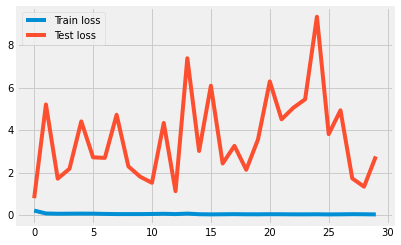

In [85]:
plt.plot(gru_1_history.history['loss'], label='Train loss')
plt.plot(gru_1_history.history['val_loss'], label='Test loss')
plt.legend();

In [83]:
# build out another gru model 
gru_2 = rnn_gs(hidden_neurons=64, hidden_layers=5, dropout=0.2)

# fit the first model
gru_2_history= gru_2.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 16s 98ms/step - loss: 0.3596 - val_loss: 3.2607
Epoch 2/30
87/87 [==============================] - 8s 88ms/step - loss: 0.0774 - val_loss: 35.5594
Epoch 3/30
87/87 [==============================] - 11s 126ms/step - loss: 0.1747 - val_loss: 5.0549
Epoch 4/30
87/87 [==============================] - 11s 123ms/step - loss: 0.0342 - val_loss: 4.2243
Epoch 5/30
87/87 [==============================] - 16s 186ms/step - loss: 0.0282 - val_loss: 1.1836
Epoch 6/30
87/87 [==============================] - 11s 120ms/step - loss: 0.0214 - val_loss: 0.4405
Epoch 7/30
87/87 [==============================] - 8s 95ms/step - loss: 0.0176 - val_loss: 0.7828
Epoch 8/30
87/87 [==============================] - 7s 86ms/step - loss: 0.0291 - val_loss: 0.3780
Epoch 9/30
87/87 [==============================] - 8s 94ms/step - loss: 0.0319 - val_loss: 3.7553
Epoch 10/30
87/87 [==============================] - 8s 87ms/step - loss: 0.0207 - val_loss: 0.2467

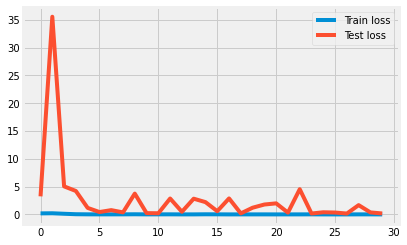

In [86]:
plt.plot(gru_2_history.history['loss'], label='Train loss')
plt.plot(gru_2_history.history['val_loss'], label='Test loss')
plt.legend();

In [84]:
# build out another gru model 
gru_3 = rnn_gs(hidden_neurons=32, hidden_layers=7, dropout=0.2)

# fit the first model
gru_3_history= gru_3.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 15s 90ms/step - loss: 0.5631 - val_loss: 0.5308
Epoch 2/30
87/87 [==============================] - 7s 79ms/step - loss: 0.0681 - val_loss: 9.1167
Epoch 3/30
87/87 [==============================] - 7s 80ms/step - loss: 0.0787 - val_loss: 6.4324
Epoch 4/30
87/87 [==============================] - 7s 81ms/step - loss: 0.0398 - val_loss: 1.5729
Epoch 5/30
87/87 [==============================] - 7s 78ms/step - loss: 0.0415 - val_loss: 1.2516
Epoch 6/30
87/87 [==============================] - 7s 78ms/step - loss: 0.0399 - val_loss: 3.9566
Epoch 7/30
87/87 [==============================] - 7s 78ms/step - loss: 0.0378 - val_loss: 1.3784
Epoch 8/30
87/87 [==============================] - 7s 79ms/step - loss: 0.0416 - val_loss: 0.4326
Epoch 9/30
87/87 [==============================] - 7s 79ms/step - loss: 0.0264 - val_loss: 0.6391
Epoch 10/30
87/87 [==============================] - 7s 79ms/step - loss: 0.0421 - val_loss: 2.6476
Epoch 11

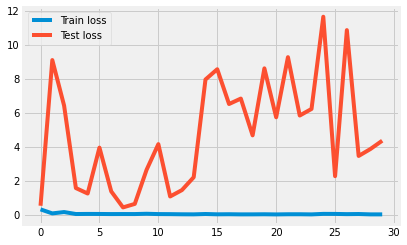

In [87]:
plt.plot(gru_3_history.history['loss'], label='Train loss')
plt.plot(gru_3_history.history['val_loss'], label='Test loss')
plt.legend();

Of these first three models, the second model appears to have performed the best when analyzing the `Test loss`. Another batch of three GRU models will be run, all will have 64 hidden_neurons, but then will change up the number of hidden layers and the dropout ratio to see if a stronger model can be created.

In [88]:
# build out another gru model 
gru_4 = rnn_gs(hidden_neurons=64, hidden_layers=7, dropout=0.2)

# fit the first model
gru_4_history= gru_4.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 20s 124ms/step - loss: 0.6588 - val_loss: 1.4981
Epoch 2/30
87/87 [==============================] - 10s 114ms/step - loss: 0.0627 - val_loss: 1.0075
Epoch 3/30
87/87 [==============================] - 10s 116ms/step - loss: 0.0580 - val_loss: 0.7434
Epoch 4/30
87/87 [==============================] - 8s 96ms/step - loss: 0.0630 - val_loss: 0.9754
Epoch 5/30
87/87 [==============================] - 9s 102ms/step - loss: 0.0365 - val_loss: 4.2872
Epoch 6/30
87/87 [==============================] - 9s 99ms/step - loss: 0.1543 - val_loss: 1.9965
Epoch 7/30
87/87 [==============================] - 9s 102ms/step - loss: 0.0259 - val_loss: 3.7615
Epoch 8/30
87/87 [==============================] - 9s 100ms/step - loss: 0.0300 - val_loss: 0.6867
Epoch 9/30
87/87 [==============================] - 10s 113ms/step - loss: 0.0198 - val_loss: 0.6006
Epoch 10/30
87/87 [==============================] - 8s 95ms/step - loss: 0.0181 - val_loss: 1.163

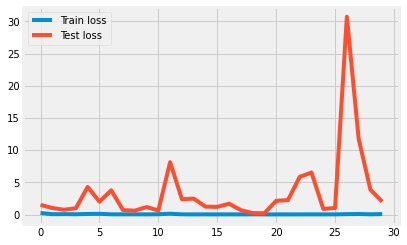

In [89]:
plt.plot(gru_4_history.history['loss'], label='Train loss')
plt.plot(gru_4_history.history['val_loss'], label='Test loss')
plt.legend();

In [90]:
# build out another gru model 
gru_5 = rnn_gs(hidden_neurons=64, hidden_layers=7, dropout=0.5)

# fit the first model
gru_5_history= gru_5.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 17s 112ms/step - loss: 0.4127 - val_loss: 6.6084
Epoch 2/30
87/87 [==============================] - 9s 101ms/step - loss: 0.0762 - val_loss: 14.9398
Epoch 3/30
87/87 [==============================] - 9s 99ms/step - loss: 0.0841 - val_loss: 9.6790
Epoch 4/30
87/87 [==============================] - 8s 96ms/step - loss: 0.1716 - val_loss: 9.5569
Epoch 5/30
87/87 [==============================] - 10s 118ms/step - loss: 0.0645 - val_loss: 8.5725
Epoch 6/30
87/87 [==============================] - 8s 97ms/step - loss: 0.4500 - val_loss: 43.8504
Epoch 7/30
87/87 [==============================] - 8s 95ms/step - loss: 0.2755 - val_loss: 29.6756
Epoch 8/30
87/87 [==============================] - 8s 96ms/step - loss: 0.1507 - val_loss: 15.4016
Epoch 9/30
87/87 [==============================] - 9s 103ms/step - loss: 0.1193 - val_loss: 15.6346
Epoch 10/30
87/87 [==============================] - 11s 122ms/step - loss: 0.0756 - val_loss: 14.

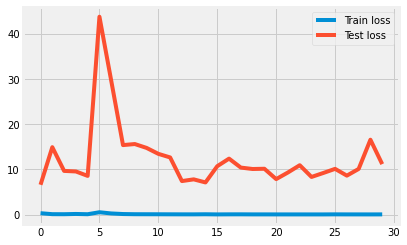

In [91]:
plt.plot(gru_5_history.history['loss'], label='Train loss')
plt.plot(gru_5_history.history['val_loss'], label='Test loss')
plt.legend();

In [92]:
# build out another gru model 
gru_6 = rnn_gs(hidden_neurons=64, hidden_layers=3, dropout=0.5)

# fit the first model
gru_6_history= gru_6.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 8s 47ms/step - loss: 0.5075 - val_loss: 1.2393
Epoch 2/30
87/87 [==============================] - 4s 44ms/step - loss: 0.0562 - val_loss: 0.9906
Epoch 3/30
87/87 [==============================] - 4s 43ms/step - loss: 0.0487 - val_loss: 2.7293
Epoch 4/30
87/87 [==============================] - 4s 43ms/step - loss: 0.0506 - val_loss: 8.5072
Epoch 5/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0719 - val_loss: 2.1685
Epoch 6/30
87/87 [==============================] - 4s 43ms/step - loss: 0.0536 - val_loss: 1.7562
Epoch 7/30
87/87 [==============================] - 4s 44ms/step - loss: 0.0365 - val_loss: 3.8781
Epoch 8/30
87/87 [==============================] - 4s 43ms/step - loss: 0.0502 - val_loss: 2.8700
Epoch 9/30
87/87 [==============================] - 4s 41ms/step - loss: 0.0199 - val_loss: 2.6390
Epoch 10/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0220 - val_loss: 2.9024
Epoch 11/

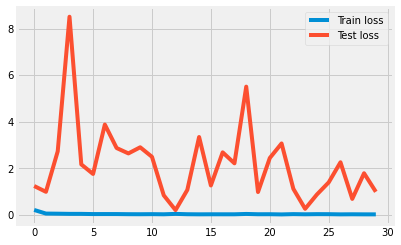

In [93]:
plt.plot(gru_6_history.history['loss'], label='Train loss')
plt.plot(gru_6_history.history['val_loss'], label='Test loss')
plt.legend();

After running 6 different manual GridSearches over the GRU neural network, none of these models have returned a better `Test loss` compared to the baseline GRU model that was created. The two GRU networks that looked to have performed the best from this batch are GRU2 and GRU4. The key similarity in these models is the dropout rate is at 0.2. No model has tested a 0.1 dropout rate which will be explored as well as a dropout rate of 0.

In [94]:
# build out another gru model 
gru_7 = rnn_gs(hidden_neurons=64, hidden_layers=5, dropout=0.1)

# fit the first model
gru_7_history= gru_7.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 14s 74ms/step - loss: 0.3952 - val_loss: 30.6606
Epoch 2/30
87/87 [==============================] - 6s 65ms/step - loss: 0.0430 - val_loss: 0.5691
Epoch 3/30
87/87 [==============================] - 6s 65ms/step - loss: 0.0443 - val_loss: 0.8243
Epoch 4/30
87/87 [==============================] - 6s 66ms/step - loss: 0.0248 - val_loss: 4.2550
Epoch 5/30
87/87 [==============================] - 6s 70ms/step - loss: 0.0111 - val_loss: 1.3839
Epoch 6/30
87/87 [==============================] - 6s 68ms/step - loss: 0.0116 - val_loss: 5.3665
Epoch 7/30
87/87 [==============================] - 6s 68ms/step - loss: 0.0506 - val_loss: 0.3326
Epoch 8/30
87/87 [==============================] - 6s 70ms/step - loss: 0.0163 - val_loss: 1.0272
Epoch 9/30
87/87 [==============================] - 6s 72ms/step - loss: 0.0248 - val_loss: 0.5347
Epoch 10/30
87/87 [==============================] - 6s 70ms/step - loss: 0.0141 - val_loss: 0.5648
Epoch 1

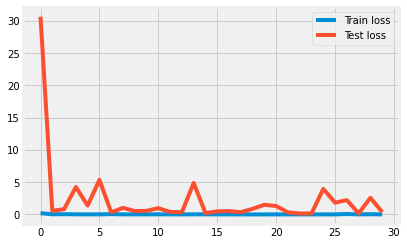

In [95]:
plt.plot(gru_7_history.history['loss'], label='Train loss')
plt.plot(gru_7_history.history['val_loss'], label='Test loss')
plt.legend();

In [96]:
# build out another gru model 
gru_8 = rnn_gs(hidden_neurons=64, hidden_layers=5, dropout=0)

# fit the first model
gru_8_history= gru_8.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 13s 78ms/step - loss: 0.5532 - val_loss: 2.1865
Epoch 2/30
87/87 [==============================] - 6s 72ms/step - loss: 0.0203 - val_loss: 0.3669
Epoch 3/30
87/87 [==============================] - 6s 72ms/step - loss: 0.0122 - val_loss: 29.3796
Epoch 4/30
87/87 [==============================] - 7s 75ms/step - loss: 0.0497 - val_loss: 7.2996
Epoch 5/30
87/87 [==============================] - 6s 72ms/step - loss: 0.0077 - val_loss: 4.3190
Epoch 6/30
87/87 [==============================] - 8s 92ms/step - loss: 0.0039 - val_loss: 1.3753
Epoch 7/30
87/87 [==============================] - 6s 73ms/step - loss: 0.0127 - val_loss: 1.9164
Epoch 8/30
87/87 [==============================] - 6s 69ms/step - loss: 0.0152 - val_loss: 5.8776
Epoch 9/30
87/87 [==============================] - 6s 69ms/step - loss: 0.0054 - val_loss: 1.4504
Epoch 10/30
87/87 [==============================] - 6s 69ms/step - loss: 0.0064 - val_loss: 9.0259
Epoch 1

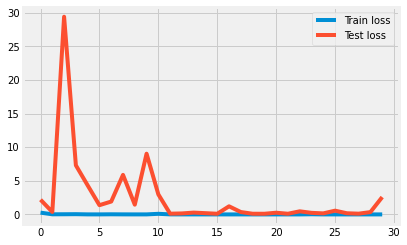

In [97]:
plt.plot(gru_8_history.history['loss'], label='Train loss')
plt.plot(gru_8_history.history['val_loss'], label='Test loss')
plt.legend();

After a quick check with the lower dropout rate, the regularization is what is hurting the network. GRU8 appears to have been the best performing model that has been created. To confirm this model is the best model created so far, a forecast and RSS will be calculated to confirm this.

In [98]:
# generate forecast
gru8_fcast = gru_8.predict(test_sequence)

# unscale the forecast
gru_8_fcast_unscaled = close_scaler.inverse_transform(gru8_fcast)

# create a df with the forecast
gru_8_fcast_df = pd.DataFrame(gru_8_fcast_unscaled, index=test_close.index[30:], columns=['forecast'])

# calculate RSS
metrics.mean_squared_error(test_close[30:], gru_8_fcast_df) * 60

7885159083.92363

The RSS for GRU8 is 7,885,159,083.92363 which is not an improvement on the baseline GRU model. Additional models will be explored to see if the baseline GRU model can be improved upon.

In [101]:
# build out another gru model 
gru_9 = rnn_gs(hidden_neurons=64, hidden_layers=3, dropout=0)

# fit the first model
gru_9_history= gru_9.fit(train_sequence, validation_data=test_sequence, epochs=30, batch_size=32)

Epoch 1/30
87/87 [==============================] - 10s 45ms/step - loss: 0.4678 - val_loss: 8.7088
Epoch 2/30
87/87 [==============================] - 4s 43ms/step - loss: 0.0245 - val_loss: 0.8519
Epoch 3/30
87/87 [==============================] - 4s 43ms/step - loss: 0.0326 - val_loss: 13.3740
Epoch 4/30
87/87 [==============================] - 4s 40ms/step - loss: 0.0166 - val_loss: 1.0870
Epoch 5/30
87/87 [==============================] - 4s 41ms/step - loss: 0.0080 - val_loss: 4.3319
Epoch 6/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0038 - val_loss: 1.6875
Epoch 7/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0044 - val_loss: 0.2482
Epoch 8/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0054 - val_loss: 0.2601
Epoch 9/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0038 - val_loss: 0.6154
Epoch 10/30
87/87 [==============================] - 4s 42ms/step - loss: 0.0023 - val_loss: 0.3364
Epoch 1

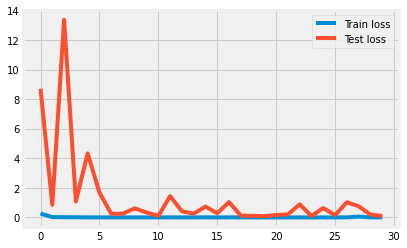

In [102]:
plt.plot(gru_9_history.history['loss'], label='Train loss')
plt.plot(gru_9_history.history['val_loss'], label='Test loss')
plt.legend();

In [103]:
# generate forecast
gru9_fcast = gru_9.predict(test_sequence)

# unscale the forecast
gru_9_fcast_unscaled = close_scaler.inverse_transform(gru9_fcast)

# create a df with the forecast
gru_9_fcast_df = pd.DataFrame(gru_9_fcast_unscaled, index=test_close.index[30:], columns=['forecast'])

# calculate RSS
metrics.mean_squared_error(test_close[30:], gru_9_fcast_df) * 60

306895354.31196207

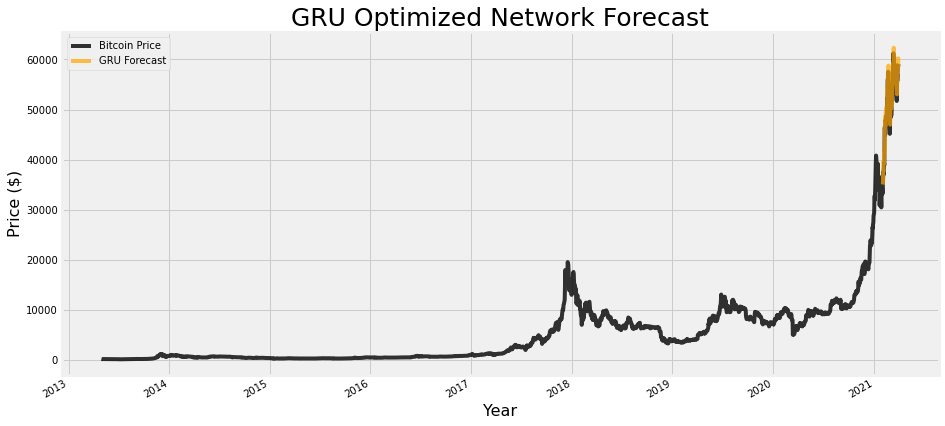

In [106]:
# plot true values
daily['close'].plot(alpha = 0.8, color='black', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot the fitted values
gru_9_fcast_df['forecast'].plot(alpha=0.7,color='orange', label='GRU Forecast', legend=True)

# add title/x/y labels
plt.title('GRU Optimized Network Forecast', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

In [105]:
# calculate RMSE
rmse = metrics.mean_squared_error(test_close[30:], gru_9_fcast_df, squared=False)

2261.6194577925867

GRU9 returned a RSS of 306,895,354.31196207 which is now the best RSS of any model/network created. The goal of creating a network that was an improvement on the GRU baseline network has been accomplished. While other networks may be able to return an even lower RSS, checking for each value will be saved for when the GridSearch can be completed.

The above graph shows the forecasted price against the actual price similar to the previous graphs shown. While the forecast window is smaller, the forecasted prices are much more in line with the real price which is why this model returned the lowest RSS score. To bring it back to the problem statement, the RMSE brings the error back into the same units as the forecast (USD) and is 2,261.62. This is well below the $6,300 level that was deemed reasonable error which means this model is able to successfully forecast the price of Bitcoin within a reasonable error level.

Below is a visualization of forecasted values, the error interval that is made up of the RMSE, and the true Bitcoin price in that time window (60 days). 

In [107]:
# create a function that will calculate RMSE on a specified interval rather than entire prediction window
# this function will be used shortly
def rmse_ma(true_val, pred, n):
    return (sum((true_val[:n] - pred[:n]) ** 2)/n)**(1/2)

In [125]:
# create a list of rmse scores where the index refers to the prediction index
ci = []

# loop through one full year worth of dates
for i in range(1, 61):

    # run rmse function created to obtain rmse scores
    ci.append(rmse_ma(test_close[30:], gru_9_fcast_df['forecast'], i))

# create an empty list for upper bound of CI
upper = []

# loop through predicted values and add the rmse at that index value to create upper bound
for i in range(len(gru_9_fcast_df)):
    upper.append(gru_9_fcast_df['forecast'][i] + ci[i])

# same as aboveloop through predicted values and subtract the rmse at that index value to create lower bound
lower = []
for i in range(len(gru_9_fcast_df)):
    lower.append(abs(gru_9_fcast_df['forecast'][i] - ci[i]))

Text(0, 0.5, 'Price ($)')

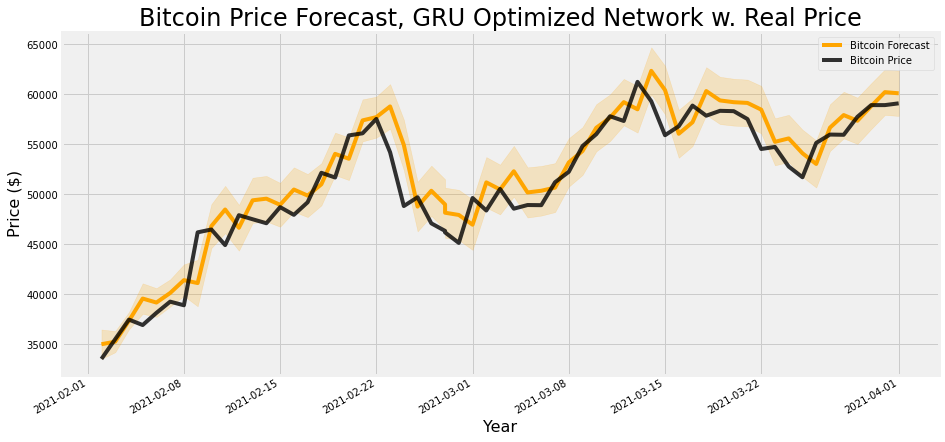

In [133]:
# graphically show the predictions with the rmse-ma as the upper and lower limits
ax = gru_9_fcast_df['forecast'].to_frame('Bitcoin Forecast').plot(figsize=(16, 9), color='orange')

# plot true values
daily['close'][-60:].plot(alpha = 0.8, color='black', label='Bitcoin Price', legend=True, figsize=(14, 7))

# use fill_between and the previously made upper and lower list
ax.fill_between(x=gru_9_fcast_df['forecast'].to_frame().index,
                y1=upper,
                y2=lower, alpha=0.2, color='orange')

# add title, x/y-axis label
plt.title("Bitcoin Price Forecast, GRU Optimized Network w. Real Price", fontsize=24)
plt.xlabel('Year', fontsize=16)
plt.ylabel("Price ($)", fontsize=16)

By using the RMSE to create an error interval, the above graph shows the forecasted Bitcoin price with its confidence interval (orange) against the true price of Bitcoin. Compared to any of the previous models, this is a significant improvement in the forecast (not surprising given the significantly lower RSS.

| Model | Optimized | AIC | RSS |
|--|--|--|--|
| ARIMA | AIC | -9,803.978875555455 | 195,663,055,382.6728 |
| ARIMA | RSS | -9,763.586525933988 | 18,940,753,598.031494 |
| SARIMA | AIC | -9,775.04078021729 | 24,573,606,014.329235 |
| SARIMA | RSS | -8,821.249991627563 | 7,395,120,381.605706 |
| Holt | AIC | 31,511.65372812618 | 17,592,924,408.176796 |
| Holt | RSS | 32,622.519073158164 | 1,649,003,709.904847 |
| Holt Winter | AIC | 31,504.365238411654 | 20,400,967,764.329018 |
| Holt Winter | RSS | 31,594.712991325876 | 1,777,842,238.3718455 |
| GRU Baseline | RSS | N/A | 527,310,145.44964737* |
| LSTM Baseline | RSS | N/A | 9,479,719,403,159.566* |
| Optimized GRU | RSS | N/A | 306,895,354.31196207* |

*The RSS for all neural networks are only calculated for a 60-day forecast while all other model's RSS is based on a 90-day forecast

While the above graph is very promising there is an important observation that needs to be addressed: a change in the Bitcoin price direction (up vs. down) is captured by the forecast on a one-day delay. This is most likely due to the true values being fed into the network and the network correcting its mistakes once the direction changes. While extremely helpful, this model is not well suited for to forecast multiple steps ahead. 

<a id="6"></a>
## Conclusion & Recommendations
___
After building out close to 8,000 different models, the GRU neural network was able to forecast the price of Bitcoin within a reasonable level. While not perfect, the GRU neural network had the smallest RSS error which also meant it had the smallest RMSE. The RMSE brings the error back to the same units as the forecast and was used to create an error interval for the forecast. This error interval covered a total range of roughly 10% from the forecast, below the 20% threshold that was a part of the problem statement. Both of the exponential models created also achieved a RMSE below the reasonable error threshold further proving that a model can be created to forecast the price of Bitcoin within a reasonable error level.

The main recommendation is to reformat the GRU neural network to forecast multiple steps ahead. The forecast can either be single-shot (makes the predictions all at once) or autoregressive (make one prediction at a time and feed the output back to the model). While autoregressive seems the best on paper, exploring both options may be beneficial to see if one or the other is better at forecasting the price of Bitcoin on quarter out.

Another recommendation would be to build a custom class to replace the `KerasRegressor`. The custom class should allow for the GRU GridSearch to be completed. While extremely helpful and it could be used for problems beyond just forecasting the price of Bitcoin, the GridSearch was focused on optimizing the above GRU network type. As previously discussed, this network is not providing forecasts multiple steps ahead which should be the priority. Once that network is built, a GridSearch over its hyperparameters should result in an optimized model.